In [31]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run Check_Derivation_of_Two_Opinions.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count
from itertools import combinations
from itertools import product
import scipy.optimize
import csv
import os
import os.path
from math import comb

# Game Parameters
# Game_rounds =200 # Rounds + 1- use for printing data
memory = 10

save_path = 'C:/Users/xzhan/OneDrive/Misinfo Paper/K Nodes - All/Sythetic Network - less memory version'

current_dir = os.getcwd()
save_path = current_dir



    # Fixed initial condition + memeory = 50

## Mathmatic Functions

In [32]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# Compute number of possible actions
def len_actions(k, n):
    # create all combination of K opinions
    max_option = [0, 1]
    
    k_opinions =list(product(max_option, repeat=k))  # All k opinion combinations
    len_kops = len(k_opinions) # - number of combinations exist
    # Horizontal length of all possible actions
    h = comb(n,k) * len_kops
    return h


# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# def obj_polarization_1(A, L, op, n):  #z_mean is the same as s_mean - according to Stanford paper theory
#     z = np.dot(A, op) 
#     z_mean = mean
#     return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

np.set_printoptions(precision=5)

In [33]:
# k = 3
# n = 20
# # #comb(n,k)
# h = len_actions(k, n)
# print(h)
def cgen(i,n,k):
    """
    returns the i-th combination of k numbers chosen from 1,2,...,n
    """
    c = []
    r = i+0
    j = -1
    for s in range(1,k+1):
        j = j+1
        while r-comb(n-1-j,k-s)>=0:
            r -= comb(n-1-j,k-s)
            j += 1
        c.append(j)
    return c


In [34]:
########### create all combination
def cgen(i,n,k):
    """
    returns the i-th combination of k numbers chosen from 1,2,...,n
    """
    c = []
    r = i+0
    j = -1
    for s in range(1,k+1):
        cs = j+1
        while r-comb(n-1-cs,k-s)>=0:
            r -= comb(n-1-cs,k-s)
            cs += 1
        c.append(cs)
        j = cs
    return c


########## input representative k_nodes, nodes needs to be excluded, return the real k nodes that are available 
def convert_available(k_nodes, touched, k):
    #touched = list(set(touched)) #[2,4,6,8] unqie values of touched
    touched.sort()
    for i in touched: 
        for j in range(k): #[2,3,4,5,6,7,8,9]   
            if k_nodes[j]>=i:
                k_nodes[j] = k_nodes[j] + 1
    return k_nodes

########### create available combination of K nodes
def creat_available_comb(i_th, n,k,touched):

    a = len(set(touched))  # number of unqiue touched nodes
    len_nodesets = comb(n-a,k) #  number of available combination of k nodes
    
    k_fake = cgen(i_th,n-a,k) # generate the i-th list from total n-a agents
    k_nodes = convert_available(k_fake, touched, k) # convert the i-th list to real k nodes

    return (k_nodes)

# def creat_all_comb(i_th, n, k):
# ########### create all combination of K opinions
#     max_option = [0, 1]
#     k_opinions =[]
#     k_opinions = product(max_option, repeat=k)  # - all k opinion combinations

#     k_nodes = cgen(i_th,n,k)
    
#     return(k_nodes, k_opinions)

def creat_all_comb(n, k):
########### create all combination of K opinions
    max_option = [0, 1]
    k_opinions =[]
    k_opinions = product(max_option, repeat=k)  # - all k opinion combinations
    
    return list(k_opinions)


def change_k_innate_opinion(s, node_set, k_opinion): # node_set - 1 set  k_opinion- 1 set
    op =  copy.copy(s) # make a copy of the innate opinion array 

    for j in range(k):
        b = node_set[j] # b - agent index
#         print('agent index' + str(b))
#         print('op length'+ str(len(op)))
#         print('k_opinions'+str(list(k_opinions)))
        op[b]=k_opinion[j]   # f - index of which opinion combination

    return op

In [35]:
# i_th = 0
# v2 = creat_available_comb(i_th, n,k,touched)
# print(v2)

In [36]:
# # i = 4
# # n = 20
# # k = 2
# # touched = [8, 17, 2, 6]
# # creat_available_comb(i, n,k,touched)
# k_nodes=[1,2]
# touched = [2,3]
# k = 2
# convert_available(k_nodes, touched, k)

### 1. Import Network

In [37]:
import numpy as np

def create_erdos_renyi_network(n, p, u, v):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
#         for j in range(i+1,n):
#             r = np.random.rand()
#             if r < p:
            if j<i:
                A[i,j] = A[j,i] = 1
#             if i==u or i==v:
#                 A[i,j] = A[j,i] = 1
    return A


# Create a synthetic Erdős-Rényi network with 10 nodes and edge probability 0.3
# p = 0.3
# u=1
# v=2

# print(s)
# # Print the adjacency matrix
# G = create_erdos_renyi_network(n, p, u, v)
# print(G)

def make_innat_opinions(n): # Make opinion for agents only - no info source is involved
    
    # Make list of ind innate opinion to define info source opinion
    innat_s = np.random.uniform(low=0, high=1, size=int(n))   #individual's innate opinion 

    s = np.zeros((n, 1))
    
    idx1 = 0
    for i in range(len(s)):
        s[i] = innat_s[idx1]  #set innate opinion for ind.
        idx1 += 1  
    return s




In [27]:
# s = make_innat_opinions(n)

In [38]:
# # #################### Import Sythetic Network Data
df = pd.read_csv (save_path+'/data/5Adj_matrix.csv', header=None)
G = np.array(df[df.columns[:]])
# # # print(G)
df1 = pd.read_csv(save_path+'/data/5innate_op.csv', header = None)
s = np.array(df1[df1.columns[:]])

# print(s)
# print(G.shape)

# # Set n according to the data
n = len(s[:])
# # print(n)

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

#n = 20 # Number of nodes

# # Create empty graph
# nxG = nx.Graph()

# # Add nodes to graph
# nxG.add_nodes_from(range(n))

# # Add edges based on node index
# for i in range(n):
#     for j in range(i):
#         p = (n-i)/(n-j) # Probability of edge existing
#         if np.random.random() < p:
#             nxG.add_edge(i, j)

# # Draw graph
# nx.draw(nxG, with_labels=True)
# plt.show()
# G = nx.adjacency_matrix(nxG).todense()
# print(G)


In [40]:
################## Process the Network Data
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
m = num_edges(L, n)                    # call the function to calculate the number of edges
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
#plt.figure(figsize=(20, 20))
# nx.draw(nxG).
columnsum_ij = np.sum(A, axis=0)
print(columnsum_ij)
# s = [0.5]*n
# s = np.reshape(s, (n, 1))
print(s)

[1. 1. 1. 1. 1.]
[[0.23068]
 [0.8871 ]
 [0.64121]
 [0.21768]
 [0.16186]]


<Figure size 1440x1440 with 0 Axes>

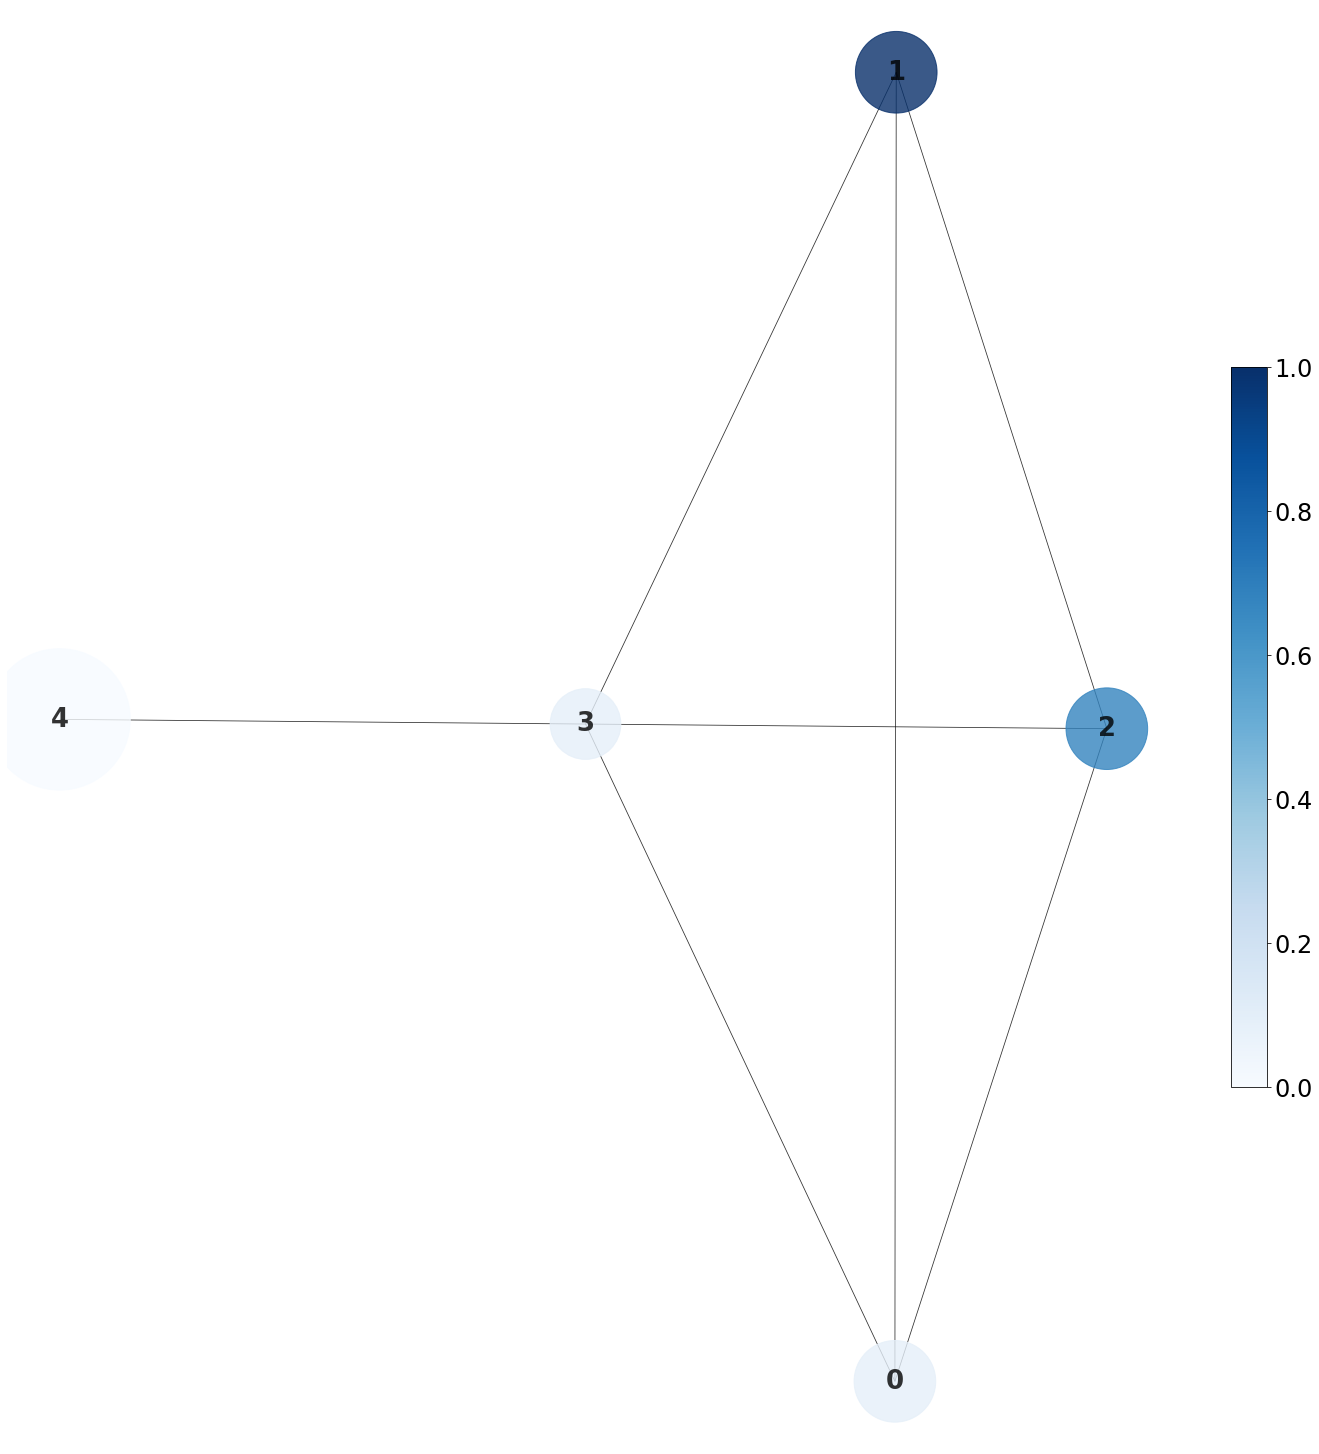

In [41]:
# what the twitter graph looks like 
s_use = s.flatten()   # Convert array to a list for later operation
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2
#_______________________________________________________

nxG = nx.from_numpy_matrix(G)   
# nxG = nx.relabel_nodes(nxG, mapping)      
plt.figure(figsize=(20, 20))


def node_edge(G, n):
    edges =[]
    for v in range(n):
        a = np.array(np.nonzero(G[v])[0])
        edge = len(a)
#         print(edge)
        edges.append(edge)
        
    return edges

node_edges = node_edge(G, n)
# print(node_edges)

node_sizes =[]
for i in node_edges:
    node_size = 1/i*20000
    node_sizes.append(node_size)

min_equi = []
max_equi = []
# Create node color
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('red')
    else:
        color_map.append('grey')
# print(node_sizes)
#-_______________________________________
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
plt.figure(figsize=(20, 20))

# Fix seed - fix network shape
my_pos = nx.spring_layout(nxG, seed = 2)
nx.draw(nxG, pos= my_pos, with_labels= True, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
#nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, shrink = 0.5)
tick_font_size = 24
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()


In [42]:
print(s)

[[0.23068]
 [0.8871 ]
 [0.64121]
 [0.21768]
 [0.16186]]


### 2. Equilibrium & Polarization 
$$P(z) = z ^T * z $$


In [43]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, s, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)

### 3. Helper Functions

In [44]:
def k_random_play(s,n,k):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
    
    ########### create all combination of K nodes
    k_opinions = creat_all_comb(n, k)
    len_nodesets = comb(n,k)

    i_th = random.randint(0,len_nodesets-1)  # randomly select an agent index
#     v_list = node_sets[v_index]
    v_list = cgen(i_th,n,k)
    
    ########### create all combination of K opinions
    len_kops = len(k_opinions) # - number of combinations exist
    op_index = random.randint(0,len_kops-1) # randomly select index for an OPINION list 
    new_op = k_opinions[op_index]  # randomly select an opininon list(0 and 1) to update the opinion array
    print('Nodes, opinions')
    print(v_list,new_op)
#     print(new_op)
    op = change_k_innate_opinion(s, v_list, new_op)

    #print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    
    por = obj_polarization(A, L, op, n)

    column = len_kops*i_th + op_index
#     print("Network reaches stead_state Polarization: " + str(por))

    return (v_list, new_op, por, column)


In [45]:
def k_random_play_1(s,n,k,max_touched):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
#     max_opi_option = random.uniform(0, 1)   # options that maximizer have

    a = len(set(max_touched))  # number of unqiue touched nodes
    len_nodesets = comb(n-a,k) #  number of available combination of k nodes
    
    i_th = random.randint(0,len_nodesets-1)  # randomly select an action index
    v_list = creat_available_comb(i_th, n,k,max_touched)
  
    new_op_list = []
    for i in range(k):
        #new_op = random.uniform(0, 1)  # randomly select an opininon between 0 and 1
        new_op = 0.5
        new_op_list.append(new_op)
   
    new_op_list = tuple(new_op_list)
    print('Nodes, opinions')
    print(v_list,new_op_list)
    op = change_k_innate_opinion(s, v_list, new_op_list)
   # print("    "+"Agent" + str(v_list) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(A, L, op, n)
#     print("Network reaches steady-state Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v_list, new_op_list, por)





In [46]:
# k = 2
# max_touched = [1,2]
# (v, new_op_list, por) =k_random_play_1(s,n,k,max_touched)
# print(v, new_op_list, por)

In [47]:
# max_touched = [0]
# v2 = [0]
# k = 2
# node_set = [1,2]
# k_opinion = [0,0]

### Mixed Strategy Payoff


In [48]:
np.set_printoptions(precision=3)
def make_k_payoff_row(op1, h, v2): #op1 here is only changed by Min
    payoff_row = np.zeros(h)
    
    column = 0 
    i = 1
    for i in range(0, comb(n,k)):# i - which set of nodes option 
#         print('nodeset'+ str(i))
        nodes = cgen(i,n,k)
#         print(nodes)
        k_opinions = creat_all_comb(n, k)

        for ops in k_opinions: # tuple index - select one combinatio of opinions
#             print('opset'+ str(j))
#             j = j + 1
            op2 = change_k_innate_opinion(op1, nodes, ops) # op2 has changed by both min and max now
            check =  any(node in nodes for node in v2)     
            
 # when v1 == v2, the polarization should be negative for max, infinet for min. 
 # Replace the the column_index of agent v2 with 0 for max                   
            if check is False:    #if v1 != v2
                # calculate the payofflarization
                payoff = obj_polarization(A, L, op2, n) # calculate the payofflarization
                payoff_row[column] = payoff
                column = column + 1  
#                 print(payoff_row) 
            else:                #if v1 == v2   
                payoff_row[column] = 10000  # use to avoid min and max choose the same agent
                column = column + 1  
#                 print(payoff_row)   
            
#     print(payoff_row)        


    return payoff_row    

In [49]:
# h =  len_actions(k, n)
# print(h)
# v2 = (1,2)
# payoff_row = make_k_payoff_row(s, h, v2)

# print(payoff_row)
# # print(len(s))

### Minimizer Mixed Strategy

In [50]:
# Calculate polarization of minimizer's Mixed Strategy
def mixed_K_min_polarization(s,v2,k_opinion,fla_max_fre):

    op1 = change_k_innate_opinion(s, v2, k_opinion) # only updated by minimizer's current change
    # calculate the polarization with both min(did above) and max's action(in make_payoff_row)
    payoff_row = make_k_payoff_row(op1, h, v2)  # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
#     print('payoff_row')
#     print(payoff_row)
    #calculate fictitious payoff - equi_min  
    payoff_cal = payoff_row * fla_max_fre # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1
                                             # payoff (2*n array) * maximizer_action_frequency (2*n array)
#     print('payoff_cal')
#     print(payoff_cal)
    mixed_pol = np.sum(payoff_cal) # add up all, calculate average/expected payoff
#     print('Mixed_pol')
#     print(mixed_pol)

    # Replace the the column_index of agent v2 with -100 for max

    payoff_row = [-10000 if ele == 10000 else ele for ele in payoff_row]


    return (mixed_pol,payoff_row)


In [51]:
node_set = [1,2]
k_opinion = [0,0]
op = change_k_innate_opinion(s, node_set, k_opinion)
print(op)

a= mixed_K_min_polarization(s,v2,k_opinion,fla_max_fre)
print(a)

NameError: name 'k' is not defined

In [52]:
############################################ k Min_opinion - Python Package Solve  ################################
# k = 2
# v2=[1,2]


############## Create the sum_term - exclude selected nodes 
#M_1= sum_term - term_out    # numerator
def sum_rest(n, op, v2):
    # Reshape opinion array
    op = np.reshape(op, (n,1))
    
    E_new =np.array([1/n] * n *n)  
    E_new = np.reshape(E_new, (n,n)) # create a n*n matrix with all elements 1
    #A_new = np.reshape(A, (n,n))
    A_new = copy.copy(A)
    A_temp=A_new-E_new
    M_new_temp=A_temp@op
    def sumFunction(x):
        s_i = op[x]*A_temp[x]
        return s_i
    np.sum(A, axis=0)   
    Out_term = np.sum([sumFunction(x) for x in v2],axis=0)  
    Out_term = np.reshape(Out_term, (n,1))
    M_rest = np.transpose(M_new_temp-Out_term)
#     print('M')
#     print(M_rest)
    return M_rest

############## Derivate min_opinions - using above result#####################################
def k_derivate_s(v2,k,n,M): 
        # k - # of selected nodes
        # V2 - selection list(k nodes) of minimier
         #  take the node index from selection list
         #  it's also the column index for these two nodes
        # op - n*1 innate opinion array that updated by maximizer
        # A - n*n adjacency matrix 

    # create a parameter array with all 1/n 
    c =np.array([1/n] * n)   
    #c = np.reshape(c, (n,1))

    ############## Create left side of '=' matrix
    def leftFunction(x,y):
        a_i = np.transpose(A[x]-c)@(A[y]-c)
        return [a_i]
    a = np.concatenate([leftFunction(x,y) for y in v2 for x in v2]) 
    a = np.reshape(a, (k,k))
#     print('a')
#     print(a)
    ############ Create right side of '=' matrix
    def rightFunction(x, M):
        Mi = np.dot(M, (A[x]-c))
        return -Mi  
    b = np.concatenate([rightFunction(x,M) for x in v2])   
#     print('b')
#     print(b)
    result = np.linalg.solve(a, b)
#     print(a,b) 
    return result


print('check result')
(x,y) = py_pack(A, s, n, v2)
(si,sl) = deriv_sty(A, s, n, v2)
print('Testing sample - 3 results should be the same:')
M_1 = sum_rest(n, s, v2)
result = k_derivate_s(v2,k,n,M_1)
print('result')
print(result)


check result


NameError: name 'v2' is not defined

In [53]:
v2 = [3,4]
print([(x,y) for y in v2 for x in v2]) 

[(3, 3), (4, 3), (3, 4), (4, 4)]


In [55]:
def min_k_mixed_opinion(s, n, v2, fla_max_fre):
    
    weight_op = 0
    weight_M = 0
    # loop for each max_action(in total 2*n) 
    k_opinions = creat_all_comb(n, k)
    len_kops = len(k_opinions)
    
    for column in range(h):

        if fla_max_fre[column] !=0:
#             print('column'+ str(column))
#             print('Probability')
#             print(round(fla_max_fre[column],3))

            if column > k:
                nodeset_index = int(column/len_kops)
                opset_index = column%len_kops
#                 print("nodeset_index, opset_index")
#                 print(nodeset_index, opset_index)
            else:
#                 print('less than 1')
                nodeset_index = 0
                opset_index = column
#                 print("nodeset_index, opset_index")
#                 print(nodeset_index, opset_index)
                
            # Calculating Max's action at this column
            v1 = cgen(nodeset_index,n,k)
            max_opinion = k_opinions[opset_index] 
#             print('v1,max_opinion')
#             print(v1,max_opinion)
            op1 = change_k_innate_opinion(s, v1, max_opinion) # change innate opinion by max action
#             print('check if max update the opinion')
#             print(op1)
   # Derivate optimal Min's opinion for nodeset v2
            M_rest = sum_rest(n, op1, v2)  #{sum}{j}(s_j(h_j -c))  - rest of terms

            weight_M = weight_M + fla_max_fre[column]*M_rest # {sum}{v} p_v * M
#             print('M')
#             print(M_rest)
#     print('M_SUM')
#     print(weight_M)
    # Got optimal Min's opinion for v2
    k_opinion = k_derivate_s(v2,k,n,weight_M) # give a set of k weighted opinions
    #check if the result is matching hand derivative or not.
    #Game 1 results should be the same because weight it's pure strategy, same result as "check_"
#     print('result')
#     print(k_opinion)
#     #%run Check_Derivation_of_Two_Opinions.ipynb
#     (x,y) = py_pack(A, op1, n, v2)
#     (si,sl) = deriv_sty(A, op1, n, v2)
    
#     print('Weighted polarization')
#     print(mixed_por)
# When the min_op is out of range(0,1), replace it with the boundary that close to min_op
    if any(x < 0 for x in k_opinion):
        print('Min_opinion less than 0') # min_opinion should be in the range (0,1)
        print(k_opinion)
        print('.')
        print('.')
        print('.')
        print('.')
    elif any(x > 1 for x in k_opinion):
        print('Min_opinion more than 1')
        print(k_opinion)
        print('.')
        print('.')
        print('.')
        print('.')
#         sys.exit()
    arry = np.array([])
    for i in k_opinion:
        if i <0:
            print(i)
            i = 0
            print(i)
            arry = np.append(arry, i)
            print(arry)
        elif i>1:
            i = 1
            arry = np.append(arry, i)  
        else:
            arry = np.append(arry, i)
            
    (mixed_por, payoff_row) = mixed_K_min_polarization(s, v2, k_opinion,fla_max_fre)   
    
    return(arry,payoff_row,mixed_por)  



In [56]:
#min_k_mixed_opinion(s, n, v2, fla_max_fre)

In [57]:
# Minimizer search: Go through each agent 

def mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = change_k_innate_opinion(s, v1, max_opinion) 
#     print('Check if op has been updated by Maximizer')
#     print(op)
    maxup_por = obj_polarization(A, L, op, n) #min_por- set a standard to compare with pol after min's action
    min_por = 1000 # store innate max updated polarization
#     print('check maxup por')
#     print(maxup_por)
#     payoffs = []    # create an empty list to store all polarizations   
    champion = (None, None, 0, None)  # assume the best action is champion

    a = len(set(max_touched))
    len_nodesets = comb(n-a,k)
    
    for i_th in range(len_nodesets):  #---- now v2 is a set of nodes
#         print('_________________________________')
#         print('Min start with'+ str(i_th) + '_th k nodes')
        
        v2 = creat_available_comb(i_th, n,k,max_touched)
#         print(v2)
        (changed_opinion, payoff_row, por) =  min_k_mixed_opinion(s, n, v2, fla_max_fre) # find the best new_op option 
                                                                                         #input innate opinion array s
#         print('Weighted polarization')
#         print(str(por)+'...')
#         print('_________________________________')

#         print("Maxup_por, por:",maxup_por, por)
#         print("Min_nodes, opi",v2, changed_opinion)
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
            champion = (v2, changed_opinion[:], payoff_row, min_por)
        
            print("champion: ",champion[0],champion[1],champion[3])

                            # update the recent option as champion  
#         else:
#             print('Innate polarization is smaller than Min action')
           
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [58]:
# print(max_touched)

In [59]:
# v1= [1,2]
# champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
# print(champion)

In [60]:
# (all_sets, k_opinions) = creat_all_comb(n, k)
# print('all_sets,k_opinions')
# print(all_sets,k_opinions)


In [61]:
####Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
def mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre): 

#     print('_______________________')
#     print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
    (v2, min_opinion, payoff_row, min_pol) = min_champion
    
    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
#         print("                                ")
        print("Minimizer finds its target agents:")
        print(v2)

        # Store innate_op of the min_selected k vertex
        old_opinion_min = [s[i] for i in v2]

#         print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
#         print('fla_max_fre')
#         print(fla_max_fre[np.nonzero(fla_max_fre)])


#         print("Payoff row")
#         print(payoff_row)
#         print("Network reaches steady-state Polarization: " + str(min_pol))

    return (tuple(v2), payoff_row, min_opinion, min_pol)                 

In [62]:
# v1 = [1,2]
# max_opinion=[1,1]
# fla_max_fre = h*[0]
# max_touched = [1,2]
# (v2, payoff_row, min_opinion, min_pol) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)

### Maximizer Mixed Strategy

In [63]:
####Op has been updated by minimizer, fla_min_fre includes min's hisotry, so maxmizer react to the innate op after that
def k_max_polarization(payoff_matrix,column,fla_min_fre):

    # create payoff matrix for maxmizer
    payoff_vector = payoff_matrix[:,column]
    print('payoff_vector',payoff_vector [np.nonzero(payoff_vector)])
#     print(fla_min_fre [np.nonzero(fla_min_fre)])
    if any(i> 10 for i in payoff_vector) >10:
        print('Error in Payoff Matrix')
        sys.exit
    #calculate fictitious payoff - equi_max  
#     print('fla_min_fre')
#     print(fla_min_fre)
    payoff_cal = payoff_vector * fla_min_fre #payoff * frequency

    mixed_pol = np.sum(payoff_cal) # add up
    #print('mixed_pol',mixed_pol)
    return mixed_pol


In [64]:
# payoff_matrix = np.empty((1, h), float)
# mixed_pol = k_max_polarization(payoff_matrix,column, fla_min_fre)
# payoff_matrix[:,1]=10
# print(payoff_matrix.shape)

In [65]:
def find_idx(k_nodes,n):

    latter=0
    index = 0
    k = len(k_nodes)
    
    for i in range(k):
        before = k_nodes[i] + 1
#         print('before')
#         print(before)
        L_min = latter + 1
        L_max = before - 1

        M = L_max - L_min

        for m in range(1, M+2):
            P = n - latter - m
            L = k -1 - i
            index = index + comb(P,L)
        latter = before
        
    return index
        

In [66]:
# n = 100
# k_nodes=cgen(123,n,4)
# a = test_1(k_nodes,n)
# print(a)

In [67]:
# # pass on the innate opinion that has been changed by minimizer
def max_k_play(payoff_matrix, op, n, k, fla_min_fre, min_touched): # - op1 - innate opinion that has been changed by minimizer
    k_opinions = creat_all_comb(n, k)
    len_kops = len(k_opinions)
    
    ############ start producing changes ###########
    count = 0
    all_por = np.zeros(h)
#     print('all_por')
#     print(all_por)
    print('fla_min_fre', fla_min_fre [np.nonzero(fla_min_fre)])
    a = len(set(min_touched)) # number of unique touched agent
    len_avsets = comb(n-a,k) # length of available k_nodes combinations
    
    for i_th in range(len_avsets): # for each available k nodes
#         print('_________________________________')
#         print('Max start with'+ str(i_th) + '_th k nodes')
        v1 = creat_available_comb(i_th, n,k,min_touched)  #for i in node_sets:  # for each available k nodes
#         print(v1)
#         print(i)
#         k_nodes_index = all_sets.index(i) 
        k_nodes_index = find_idx(v1,n) # map this nodeset to its index located in all lists
        
        for f in range(len_kops):         # for each opinion combination 
            column = k_nodes_index*len_kops + f  # locate the column in payoff row- all combinations
            #por = obj_polarization(A, L, s, n)
            por= k_max_polarization(payoff_matrix, column, fla_min_fre) # calculate mixed polarization      
            all_por[column] = por
             
        print('Max_por', max(all_por))
    print('all_por', all_por)
    # ############# best action ##########
#     print('all_por')
    #print('Max_por', max(all_por))
    column = np.argmax(all_por) # Index of maximum polarization - in all actions
    print('column - best action')
    print(column)

    
    (v1, max_opinion) = map_action(n,k,column)
#     print('v1,max_opinion')
#     print(v1,max_opinion)
    # print(all_sets)

    # # Find innate opinion of k nodes - Comment - testing use
    # old_opinion_max = [s[i] for i in v1]
    print("                                ")
    print("Maximizer finds its target "+str(k)+ " agent:")
    print(str(v1) + "  op:" + str(max_opinion))

    ## check if agent's opinionis is changed or not
#     print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#     print("Network reaches steady-state Polarization: " + str(np.max(all_por)))

    return(v1, max_opinion, np.max(all_por), column)



In [68]:
# payoff_matrix = np.empty((0, h), float)
# fla_min_fre = np.array(h*[0])
# fla_min_fre[1] = 1
# print(fla_min_fre)

# min_touched = [13,15]

a = max_k_play(payoff_matrix, s, n, k, fla_min_fre, min_touched)
print('v1, max_opinion, np.max(all_por), column')
print(a)


NameError: name 'payoff_matrix' is not defined

In [69]:
# column = 286
# map_action(n,k,column)

## 5. Innate Op and Game

# Fictitious Play Start !


In [70]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, op, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)



In [71]:
# # Game Parameters
# Game_rounds =200 # Rounds + 1- use for printing data
# memory = 50

# Game Preparation
def push(obj, element):
    if len(obj) >= memory:
        dif = len(obj) - memory
        obj.pop(dif)
    obj.extend(list(element))
    obj = list(set(obj))
    
    return obj


In [72]:
def map_action(n,k,column):

    k_opinions = creat_all_comb(n, k)
    len_kops = len(k_opinions)
    nodeset_index = int(column/len_kops) 
    opset_index = column%len_kops
    k_nodes = cgen(nodeset_index, n, k)
    opinions = k_opinions[opset_index]
    
    return (k_nodes, opinions)

Game_rounds = 0
## Testing use
k = 2
experiment = 1
h = len_actions(k, n)
print(n)

5


In [73]:
# def excute(h, k, Game_rounds):
# Preparation for the game
op = copy.copy(s)
payoff_matrix = np.empty((0, h), float)
max_history = np.zeros(h, int)  # n*2 matrix, agent i & opinion options
min_history = []  # append a list of (agent i, min_opinion), min_opinion can be any value
#     print(type(min_history))

max_history_last_100 = np.zeros(h, int) 
min_history_last_100= []

max_touched = []
min_touched = []
min_touched_all = []
min_touched_last_100 =[]


# Game start from maximizer random play
#     print('Maximizer first selection')
#(v1, max_opinion, max_pol, column) = k_random_play(s,n,k)
#(v1, max_opinion, max_pol) = random_play(op,n)   # Maximizer does random action 
#(v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)

#(v1, max_opinion, max_pol)  = ((6,19),(1,0),0) 

(v1, max_opinion, max_pol, column) = ([0, 2], (1, 1), 0.1270803458329454, 7)
First_max = (v1, max_opinion, max_pol, column)
print('First_max',First_max)


# Maximizer start with greedy play
# (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)   # Maximizer choose action greedily

max_touched.extend(tuple(v1))
#     print('max_touched')
#     print(max_touched)
# store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
########################################################
max_history[column] = max_history[column] +1
# print('max_history')
# print(max_history)
#     print('history at spot')
#     print(max_history[column])

fla_max_fre = max_history/1  # its frequency, only played  1 time so far, divided by 1 

#     print('fla_max_fre')
#     print(fla_max_fre)
#fla_max_fre = max_frequency.flatten()   # flatten the n*2 matrix to a 2n*1 matrix
                                        # so we can multiply the freuency (2n*1)with payoff array (1*2n) 
                                        # to get average payoff of fictitious play

# if game start from minimizer random play - make sure two random play are not same agent!!!
#     print('Minimizer first selection')
#(v2, min_opinion, min_pol) = k_random_play_1(s,n,k,max_touched)
#(v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)

(v2, min_opinion, min_pol) = ([1, 3], (0.5, 0.5), 0.020147309098439665) 
First_min = (v2, min_opinion, min_pol)
print('First_min:', First_min)
# (v2, min_opinion, min_pol) = ((13,15),(0.5,0.5),1)
#(v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)

if any(x in v1 for x in v2): # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
    sys.exit()

# Minimizer start with greedy play
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
min_touched.extend(v2)
min_touched_all.append(tuple(v2)) 
# store minimizer play history
#############################################################
min_history.append((tuple(v2), tuple(min_opinion)))
print('min_history')
print(min_history)
counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
#     print(counter)
fla_min_fre = np.array(list(counter.values()))/1 #return only frequency of all min options in order
#     print('fla_min_fre')
#     print(fla_min_fre)

#     (mixed_pol,payoff_row)

(a,payoff_row) = mixed_K_min_polarization(s, v2, min_opinion,fla_max_fre)
# print('payoff_row')
# print(payoff_row)
######################################################################
payoff_matrix = np.vstack([payoff_matrix, payoff_row])
#     print('Payoff Matrix')
#     print(payoff_matrix)
min_counter = dict(counter)
#     print('fla_min_fre at the spot')
#     print(min_counter)
#     print(min_counter[(v2+min_opinion)]) 
#     print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)
equi_min = min_pol
equi_max = max_pol
# print(equi_min)
# print(equi_max)


Flag = 0

i = 0
while Flag == 0: 
    i = i + 1
    print("Game " + str(i))
    print("_____________________")
    print('min_history', min_history)
    print('max_history', max_history)


#     if max_pol == min_pol:
    if i == Game_rounds:            # i == # of iterations you want to run + 2
                            # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
        print('MAX_last_100,  all')  
        max_l100_fre = max_history_last_100/100
        max_fre = max_history/Game_rounds
        print(max_l100_fre [np.nonzero(max_l100_fre)], max_fre[np.nonzero(max_fre)])
        print(np.nonzero(max_l100_fre)[0], np.nonzero(max_fre)[0])
        columns = list(np.nonzero(max_l100_fre)[0])
        for column in list(columns):
                k_opinions = creat_all_comb(n, k)
                len_kops = len(k_opinions)
                nodeset_index = int(column/len_kops) 
                opset_index = column%len_kops
                k_nodes = cgen(nodeset_index, n, k)

                opinions = k_opinions[opset_index]
                print('Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions))



        # MINimizer's Strategy in the last 100 round
        counter=collections.Counter(min_touched_last_100)
        fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
        print('MIN_last_100,  all')
        counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
        fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
        print(fla_min_fre, fla_min_fre_1)
        print(counter, counter_1)
        print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))

        break

    elif equi_min == equi_max:
        print("Reached Nash Equilibrium at game"+ str(i) + "and Equi_Por = " + str(equi_min))
#             print('max_distribution')
#             print(max_frequency)
#             print('min_distribution')
#             print(fla_min_fre)
        Flag = 1
        break
#________________________________________________________________
    ############################## maximizer play  
    else:
        if i == Game_rounds-100:    #if Game_round = 200, after 100 iteration, Game 101 print previous historical result

        # Remove max frequncy less than 0.1--
            max_history_last_100 = np.zeros(h) 
            min_history_last_100 = [] 
            min_touched_last_100 =[]

        (v1, max_opinion, equi_max, column) = max_k_play(payoff_matrix, op, n, k, fla_min_fre, min_touched)
        #(v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
        max_touched = push(max_touched, v1)
        #max_touched.extend(list(v1))


        # cumulate strategy 
        max_history[column] = max_history[column] +1

        max_history_last_100[column] = max_history_last_100[column] +1
        #print('max_history', max_history)

        fla_max_fre = max_history/(i+1)  # max_frequency to calculate average payoff
        #print('fla_max_fre',fla_max_fre)
#             print(fla_max_fre)
        print('fre_max at spot')
        print(fla_max_fre[column])
#         print(fla_max_fre)

#________________________________________________________________
############################### MINImizer play
        (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
#         print('v2')
#         print(v2)
        min_touched = push(min_touched, v2)
        min_touched_all.append(v2) 
        min_touched_last_100.append(v2)

        #         print(v2, min_opinion, min_pol)
        if tuple(tuple(v2)+min_opinion) in counter.keys():
            payoff_matrix = payoff_matrix # if this min_option is in min_history, no need to update paryoff matrix, only update frequency
#                 print("Same history")
#                 print((str(v2),str(min_opinion)))
        else:
            payoff_matrix = np.vstack([payoff_matrix, payoff_row]) # if this is a new option, append to previous matrix
#                 print('payoff_row')
#                 print(payoff_row)

        min_history.append((tuple(v2), tuple(min_opinion)))  
        min_history_last_100.append(tuple(v2 + min_opinion))
        print('min_history')
        print(min_history)
        counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
        print(counter)
#             print('counter.keys:', counter.keys())
#         print(counter.keys())
        fla_min_fre = np.array(list(counter.values()))/(i+1) #return only frequency of all min options in order
        print('fla_min_fre:',fla_min_fre)
#             print(fla_min_fre)
#             print("Not Reached Nash Equilibrium at Equi_Min = " + str(equi_min) + " and Equi_Max = "+ str(equi_max)) 

result = (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min)

#     return result

First_max ([0, 2], (1, 1), 0.1270803458329454, 7)
First_min: ([1, 3], (0.5, 0.5), 0.020147309098439665)
min_history
[((1, 3), (0.5, 0.5))]
Game 1
_____________________
min_history [((1, 3), (0.5, 0.5))]
max_history [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
fla_min_fre [1.]
payoff_vector [0.009]
payoff_vector [0.042]
payoff_vector [0.042]
payoff_vector [0.092]
Max_por 0.09181344162282337
payoff_vector [0.037]
payoff_vector [0.081]
payoff_vector [0.101]
payoff_vector [0.022]
Max_por 0.10085992937712414
payoff_vector [0.018]
payoff_vector [0.112]
payoff_vector [0.075]
payoff_vector [0.046]
Max_por 0.11239874284511507
all_por [0.    0.    0.    0.    0.009 0.042 0.042 0.092 0.    0.    0.    0.
 0.037 0.081 0.101 0.022 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.018 0.112 0.075 0.046
 0.    0.    0.    0.   ]
column - best action
33
                                
Maximizer finds its target 2 agen

champion:  [1, 3] [0.581 0.51 ] 0.10606099758407594
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412))]
Counter({((1, 3), (0.5, 0.5)): 1, ((1, 3), (0.5882780441578948, 0.5711371437894737)): 1, ((1, 3), (0.8186409501052633, 0.5899284238596492)): 1, ((1, 3), (0.5491959320921054, 0.5288260252105262)): 1, ((1, 3), (0.3875289212842106, 0.4921645860210527

champion:  [1, 3] [0.554 0.501] 0.10633046309509261
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

 0.038 0.04  0.041 0.043]
Max_por 0.10752117606079553
all_por [0.    0.    0.    0.    0.012 0.046 0.046 0.097 0.    0.    0.    0.
 0.043 0.076 0.108 0.019 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.023 0.107 0.081 0.042
 0.    0.    0.    0.   ]
column - best action
14
                                
Maximizer finds its target 2 agent:
[0, 4]  op:(1, 0)
fre_max at spot
0.4482758620689655
champion:  [1, 3] [0.542 0.497] 0.1064284941136759
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), 

 0.099 0.101]
Max_por 0.09683595299493525
payoff_vector [0.037 0.043 0.06  0.04  0.032 0.039 0.046 0.052 0.044 0.039 0.035 0.039
 0.042 0.045 0.048 0.044 0.041 0.038 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.046 0.043 0.041 0.04  0.038 0.037 0.038 0.039 0.041 0.042 0.043
 0.044 0.046]
payoff_vector [0.081 0.075 0.064 0.078 0.089 0.079 0.072 0.068 0.074 0.079 0.084 0.08
 0.076 0.073 0.071 0.074 0.077 0.08  0.083 0.08  0.078 0.076 0.074 0.072
 0.071 0.073 0.075 0.077 0.078 0.08  0.082 0.08  0.079 0.077 0.076 0.075
 0.074 0.073]
payoff_vector [0.101 0.108 0.129 0.105 0.093 0.104 0.112 0.119 0.11  0.103 0.098 0.103
 0.107 0.111 0.115 0.11  0.106 0.102 0.099 0.102 0.105 0.108 0.11  0.112
 0.115 0.111 0.109 0.106 0.104 0.102 0.1   0.102 0.104 0.105 0.107 0.109
 0.11  0.112]
payoff_vector [0.022 0.018 0.01  0.02  0.029 0.021 0.016 0.013 0.017 0.021 0.025 0.021
 0.019 0.017 0.015 0.017 0.019 0.022 0.024 0.022 0.02  0.018 0.017 0.016
 0.015 0.016 0.018 0.019 0.021 0.022 0.023 0.022 0.021 0.0

champion:  [1, 3] [0.514 0.49 ] 0.10642013814335435
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

payoff_vector [0.018 0.024 0.04  0.021 0.014 0.02  0.027 0.032 0.025 0.02  0.016 0.02
 0.023 0.026 0.028 0.025 0.022 0.019 0.017 0.019 0.021 0.023 0.025 0.026
 0.028 0.026 0.024 0.022 0.02  0.019 0.018 0.019 0.02  0.021 0.023 0.024
 0.025 0.026 0.027 0.025 0.024 0.023 0.022 0.021 0.02  0.019 0.02  0.021
 0.021 0.022 0.023 0.024 0.025]
payoff_vector [0.112 0.106 0.094 0.109 0.121 0.11  0.103 0.098 0.105 0.111 0.116 0.111
 0.107 0.103 0.101 0.104 0.108 0.111 0.114 0.111 0.108 0.106 0.104 0.103
 0.101 0.103 0.105 0.107 0.109 0.111 0.113 0.111 0.11  0.108 0.107 0.105
 0.104 0.103 0.102 0.104 0.105 0.106 0.108 0.109 0.11  0.111 0.11  0.109
 0.108 0.107 0.106 0.105 0.104]
payoff_vector [0.075 0.081 0.101 0.078 0.068 0.077 0.085 0.092 0.083 0.076 0.072 0.076
 0.08  0.084 0.088 0.083 0.079 0.076 0.073 0.076 0.078 0.081 0.083 0.085
 0.087 0.084 0.082 0.08  0.078 0.076 0.074 0.076 0.077 0.079 0.08  0.082
 0.083 0.084 0.086 0.084 0.082 0.081 0.079 0.078 0.077 0.076 0.077 0.078
 0.079 0.08  0.081 

champion:  [1, 3] [0.537 0.494] 0.10659752964370771
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

champion:  [1, 3] [0.619 0.508] 0.10662081387637742
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

 0.1   0.099 0.098 0.098 0.097]
Max_por 0.09696306679801567
payoff_vector [0.037 0.043 0.06  0.04  0.032 0.039 0.046 0.052 0.044 0.039 0.035 0.039
 0.042 0.045 0.048 0.044 0.041 0.038 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.046 0.043 0.041 0.04  0.038 0.037 0.038 0.039 0.041 0.042 0.043
 0.044 0.046 0.047 0.045 0.044 0.042 0.041 0.04  0.039 0.038 0.039 0.04
 0.041 0.042 0.043 0.043 0.044 0.045 0.046 0.045 0.044 0.043 0.042 0.041
 0.04  0.039 0.039 0.039 0.04  0.041 0.041 0.042 0.043 0.043 0.044 0.045
 0.045 0.044 0.044 0.043 0.042]
payoff_vector [0.081 0.075 0.064 0.078 0.089 0.079 0.072 0.068 0.074 0.079 0.084 0.08
 0.076 0.073 0.071 0.074 0.077 0.08  0.083 0.08  0.078 0.076 0.074 0.072
 0.071 0.073 0.075 0.077 0.078 0.08  0.082 0.08  0.079 0.077 0.076 0.075
 0.074 0.073 0.072 0.073 0.074 0.076 0.077 0.078 0.079 0.08  0.079 0.078
 0.077 0.076 0.075 0.075 0.074 0.073 0.073 0.074 0.074 0.075 0.076 0.077
 0.078 0.079 0.079 0.079 0.078 0.077 0.077 0.076 0.075 0.075 0.074 0.074
 0.073

[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.4959173774269006)), ((1, 3), (0.4778546361468145, 0.48800166436565096)), ((1, 3), (0.51793024243

payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.043 0.044
 0.044 0.045 0.046 0.046 0.047 0.048 0.048 0.047 0.047 0.046 0.045 0.044
 0.044 0.043 0.043 0.043 0.044 0.044 0.045 0.045 0.046 0.046 0.047 0.047
 0.048 0.047 0.046 0.046 0.045 0.045 0.044 0.044 0.043 0.043 0.043 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.047]
payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.043 0.044
 0.044 0.045 0.046 0.046 0.047 0.048 0.048 0.047 0.047 0.046 0.045 0.044
 0.044 0.043 0.043 0.043 0.044 0.044 0.045 0.0

champion:  [1, 3] [0.582 0.501] 0.10673764116534609
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.4959173774269006)), ((1, 3), (0.4778546361468145, 0.488001664

 0.009 0.009 0.009 0.009 0.009]
payoff_vector [0.009 0.013 0.023 0.011 0.007 0.01  0.014 0.017 0.013 0.01  0.008 0.01
 0.012 0.013 0.015 0.013 0.011 0.01  0.008 0.01  0.011 0.012 0.013 0.014
 0.015 0.013 0.012 0.011 0.01  0.009 0.009 0.009 0.01  0.011 0.011 0.012
 0.013 0.013 0.014 0.013 0.012 0.012 0.011 0.01  0.01  0.009 0.01  0.01
 0.011 0.011 0.012 0.012 0.013 0.013 0.014 0.013 0.012 0.012 0.011 0.011
 0.01  0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.012 0.012 0.012 0.013
 0.013 0.013 0.012 0.012 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01
 0.011 0.011 0.011 0.011 0.012 0.012 0.012 0.013 0.013 0.013 0.013 0.012
 0.012 0.012 0.011 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.011
 0.011 0.011 0.011 0.011 0.012]
payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.04

 0.041 0.041 0.042 0.042 0.042 0.043 0.043 0.044 0.044 0.044 0.044]
payoff_vector [0.081 0.075 0.064 0.078 0.089 0.079 0.072 0.068 0.074 0.079 0.084 0.08
 0.076 0.073 0.071 0.074 0.077 0.08  0.083 0.08  0.078 0.076 0.074 0.072
 0.071 0.073 0.075 0.077 0.078 0.08  0.082 0.08  0.079 0.077 0.076 0.075
 0.074 0.073 0.072 0.073 0.074 0.076 0.077 0.078 0.079 0.08  0.079 0.078
 0.077 0.076 0.075 0.075 0.074 0.073 0.073 0.074 0.074 0.075 0.076 0.077
 0.078 0.079 0.079 0.079 0.078 0.077 0.077 0.076 0.075 0.075 0.074 0.074
 0.073 0.074 0.075 0.075 0.076 0.077 0.077 0.078 0.078 0.079 0.078 0.078
 0.077 0.077 0.076 0.076 0.075 0.075 0.075 0.074 0.074 0.073 0.074 0.074
 0.075 0.075 0.076 0.076 0.077 0.077 0.078 0.078 0.079 0.078 0.078 0.078
 0.077 0.077 0.076 0.076 0.076 0.075 0.075 0.075 0.074 0.074 0.074]
payoff_vector [0.101 0.108 0.129 0.105 0.093 0.104 0.112 0.119 0.11  0.103 0.098 0.103
 0.107 0.111 0.115 0.11  0.106 0.102 0.099 0.102 0.105 0.108 0.11  0.112
 0.115 0.111 0.109 0.106 0.104 0.1

payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.043 0.044
 0.044 0.045 0.046 0.046 0.047 0.048 0.048 0.047 0.047 0.046 0.045 0.044
 0.044 0.043 0.043 0.043 0.044 0.044 0.045 0.045 0.046 0.046 0.047 0.047
 0.048 0.047 0.046 0.046 0.045 0.045 0.044 0.044 0.043 0.043 0.043 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.047 0.047 0.048 0.047 0.047
 0.046 0.046 0.045 0.045 0.044 0.044 0.044 0.043 0.043 0.043 0.044 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.046 0.047 0.047 0.047 0.046
 0.046 0.046 0.045 0.045 0.045 0.044]
payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.0

fla_min_fre [0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007]
payoff_vector [0.009 0.013 0.023 0.011 0.007 0.01  0.014 0.017 0.013 0.01  0.008 0.01
 0.012 0.013 0.015 0.013 0.011 0.01  0.008 0.01  0.011 0.012 0.013 0.014
 0.015 0.013

 0.007 0.007 0.007 0.007 0.007]
Game 137
_____________________
min_history [((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.4959173774269006)), ((1, 3), (0.47785463

champion:  [1, 3] [0.587 0.502] 0.10676541963632498
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

champion:  [1, 3] [0.562 0.497] 0.10676080454873652
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

Max_por 0.10690432598535445
payoff_vector [0.018 0.024 0.04  0.021 0.014 0.02  0.027 0.032 0.025 0.02  0.016 0.02
 0.023 0.026 0.028 0.025 0.022 0.019 0.017 0.019 0.021 0.023 0.025 0.026
 0.028 0.026 0.024 0.022 0.02  0.019 0.018 0.019 0.02  0.021 0.023 0.024
 0.025 0.026 0.027 0.025 0.024 0.023 0.022 0.021 0.02  0.019 0.02  0.021
 0.021 0.022 0.023 0.024 0.025 0.025 0.026 0.025 0.024 0.023 0.022 0.022
 0.021 0.02  0.019 0.02  0.021 0.021 0.022 0.023 0.023 0.024 0.024 0.025
 0.025 0.025 0.024 0.023 0.023 0.022 0.021 0.021 0.02  0.02  0.02  0.021
 0.021 0.022 0.022 0.023 0.023 0.024 0.024 0.024 0.025 0.025 0.025 0.024
 0.024 0.023 0.023 0.022 0.022 0.021 0.021 0.02  0.02  0.02  0.021 0.021
 0.021 0.022 0.022 0.022 0.023 0.023 0.024 0.024 0.024 0.025 0.024 0.024
 0.023 0.023 0.022 0.022 0.022 0.021 0.021 0.021 0.021 0.021 0.022 0.022
 0.022 0.022 0.023 0.023 0.023 0.024 0.024 0.024 0.023 0.023 0.023 0.022
 0.022 0.022 0.021 0.021 0.021 0.021 0.022 0.022 0.022 0.023]
payoff_vector [0.112 

Maximizer finds its target 2 agent:
[0, 4]  op:(1, 0)
fre_max at spot
0.4375
champion:  [1, 3] [0.598 0.503] 0.10675931003989084
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



champion:  [1, 3] [0.581 0.5  ] 0.10678583790383495
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

 0.005]
payoff_vector [0.009 0.013 0.023 0.011 0.007 0.01  0.014 0.017 0.013 0.01  0.008 0.01
 0.012 0.013 0.015 0.013 0.011 0.01  0.008 0.01  0.011 0.012 0.013 0.014
 0.015 0.013 0.012 0.011 0.01  0.009 0.009 0.009 0.01  0.011 0.011 0.012
 0.013 0.013 0.014 0.013 0.012 0.012 0.011 0.01  0.01  0.009 0.01  0.01
 0.011 0.011 0.012 0.012 0.013 0.013 0.014 0.013 0.012 0.012 0.011 0.011
 0.01  0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.012 0.012 0.012 0.013
 0.013 0.013 0.012 0.012 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01
 0.011 0.011 0.011 0.011 0.012 0.012 0.012 0.013 0.013 0.013 0.013 0.012
 0.012 0.012 0.011 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.011
 0.011 0.011 0.011 0.011 0.012 0.012 0.012 0.012 0.012 0.013 0.012 0.012
 0.012 0.012 0.011 0.011 0.011 0.011 0.011 0.01  0.01  0.011 0.011 0.011
 0.011 0.011 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.011 0.011
 0.011 0.011 0.011 0.01  0.011 0.011 0.011 0.011 0.011 0.011 0.012 0.012
 0.012 0.012 0.012 0.012 0.012 0

 0.02  0.02  0.02  0.019 0.019 0.019]
Max_por 0.10688838097400927
payoff_vector [0.018 0.024 0.04  0.021 0.014 0.02  0.027 0.032 0.025 0.02  0.016 0.02
 0.023 0.026 0.028 0.025 0.022 0.019 0.017 0.019 0.021 0.023 0.025 0.026
 0.028 0.026 0.024 0.022 0.02  0.019 0.018 0.019 0.02  0.021 0.023 0.024
 0.025 0.026 0.027 0.025 0.024 0.023 0.022 0.021 0.02  0.019 0.02  0.021
 0.021 0.022 0.023 0.024 0.025 0.025 0.026 0.025 0.024 0.023 0.022 0.022
 0.021 0.02  0.019 0.02  0.021 0.021 0.022 0.023 0.023 0.024 0.024 0.025
 0.025 0.025 0.024 0.023 0.023 0.022 0.021 0.021 0.02  0.02  0.02  0.021
 0.021 0.022 0.022 0.023 0.023 0.024 0.024 0.024 0.025 0.025 0.025 0.024
 0.024 0.023 0.023 0.022 0.022 0.021 0.021 0.02  0.02  0.02  0.021 0.021
 0.021 0.022 0.022 0.022 0.023 0.023 0.024 0.024 0.024 0.025 0.024 0.024
 0.023 0.023 0.022 0.022 0.022 0.021 0.021 0.021 0.021 0.021 0.022 0.022
 0.022 0.022 0.023 0.023 0.023 0.024 0.024 0.024 0.023 0.023 0.023 0.022
 0.022 0.022 0.021 0.021 0.021 0.021 0.022 0.

 0.078 0.079 0.079 0.079 0.079 0.08  0.08  0.08  0.08  0.081]
payoff_vector [0.046 0.041 0.032 0.044 0.054 0.044 0.039 0.036 0.04  0.045 0.049 0.045
 0.042 0.04  0.038 0.04  0.043 0.045 0.048 0.046 0.044 0.042 0.04  0.039
 0.038 0.04  0.041 0.043 0.044 0.046 0.047 0.046 0.044 0.043 0.042 0.041
 0.04  0.04  0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.045 0.044
 0.043 0.042 0.042 0.041 0.041 0.04  0.039 0.04  0.041 0.042 0.042 0.043
 0.044 0.044 0.045 0.045 0.044 0.043 0.043 0.042 0.042 0.041 0.041 0.04
 0.04  0.04  0.041 0.042 0.042 0.043 0.043 0.044 0.044 0.045 0.044 0.044
 0.043 0.043 0.043 0.042 0.042 0.041 0.041 0.041 0.04  0.04  0.04  0.041
 0.041 0.042 0.042 0.043 0.043 0.043 0.044 0.044 0.045 0.044 0.044 0.044
 0.043 0.043 0.043 0.042 0.042 0.042 0.041 0.041 0.041 0.04  0.041 0.041
 0.042 0.042 0.042 0.043 0.043 0.043 0.044 0.044 0.044 0.043 0.043 0.043
 0.043 0.042 0.042 0.042 0.041 0.041 0.041 0.041 0.042 0.042 0.042 0.042
 0.043 0.043 0.043 0.044 0.043 0.043 0.043 0.043 

champion:  [1, 3] [0.596 0.503] 0.10677591668026154
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

 0.012 0.012 0.012 0.012 0.012]
payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.043 0.044
 0.044 0.045 0.046 0.046 0.047 0.048 0.048 0.047 0.047 0.046 0.045 0.044
 0.044 0.043 0.043 0.043 0.044 0.044 0.045 0.045 0.046 0.046 0.047 0.047
 0.048 0.047 0.046 0.046 0.045 0.045 0.044 0.044 0.043 0.043 0.043 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.047 0.047 0.048 0.047 0.047
 0.046 0.046 0.045 0.045 0.044 0.044 0.044 0.043 0.043 0.043 0.044 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.046 0.047 0.047 0.047 0.046
 0.046 0.046 0.045 0.045 0.045 0.044 0.044 0.044 0.044 0.044 0.044 0.045
 0.045 0.045 0.045 0.046 0.046 0.046 0.047 0.046 0.046 0.046 0.045 0.045
 0.045 0.044 0.044 0.044 0.044 0.044 0.045 0.045 0.045 0.045 0.045 0.046
 0.04

champion:  [1, 3] [0.572 0.499] 0.10679097641566498
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

champion:  [1, 3] [0.557 0.496] 0.1067717976576875
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.4959173774

champion:  [1, 3] [0.573 0.499] 0.10679340348333868
Minimizer finds its target agents:
[1, 3]
min_history
[((1, 3), (0.5, 0.5)), ((1, 3), (0.5882780441578948, 0.5711371437894737)), ((1, 3), (0.8186409501052633, 0.5899284238596492)), ((1, 3), (0.5491959320921054, 0.5288260252105262)), ((1, 3), (0.3875289212842106, 0.49216458602105273)), ((1, 3), (0.5361685614035089, 0.5147223190175438)), ((1, 3), (0.6423397329172932, 0.530834985443609)), ((1, 3), (0.7219681115526315, 0.5429194852631579)), ((1, 3), (0.6129561967192984, 0.5209860790409357)), ((1, 3), (0.5257466648526318, 0.5034393540631579)), ((1, 3), (0.4543934115071771, 0.4890829427177033)), ((1, 3), (0.5231411907149124, 0.5006186128245615)), ((1, 3), (0.5813123885060729, 0.5103795644534412)), ((1, 3), (0.6311734151842106, 0.5187460944210526)), ((1, 3), (0.67438630497193, 0.5259970870596492)), ((1, 3), (0.6160409657894738, 0.5147171959473684)), ((1, 3), (0.5645597841578949, 0.5047643508482973)), ((1, 3), (0.5187987338187136, 0.495917377

payoff_vector [0.042 0.046 0.06  0.044 0.038 0.043 0.049 0.053 0.047 0.043 0.04  0.043
 0.045 0.048 0.05  0.047 0.044 0.042 0.041 0.042 0.044 0.046 0.047 0.049
 0.05  0.048 0.046 0.045 0.043 0.042 0.041 0.042 0.043 0.044 0.045 0.046
 0.047 0.048 0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.043 0.044
 0.044 0.045 0.046 0.046 0.047 0.048 0.048 0.047 0.047 0.046 0.045 0.044
 0.044 0.043 0.043 0.043 0.044 0.044 0.045 0.045 0.046 0.046 0.047 0.047
 0.048 0.047 0.046 0.046 0.045 0.045 0.044 0.044 0.043 0.043 0.043 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.047 0.047 0.048 0.047 0.047
 0.046 0.046 0.045 0.045 0.044 0.044 0.044 0.043 0.043 0.043 0.044 0.044
 0.044 0.045 0.045 0.045 0.046 0.046 0.046 0.046 0.047 0.047 0.047 0.046
 0.046 0.046 0.045 0.045 0.045 0.044 0.044 0.044 0.044 0.044 0.044 0.045
 0.045 0.045 0.045 0.046 0.046 0.046 0.047 0.046 0.046 0.046 0.045 0.045
 0.045 0.044 0.044 0.044 0.044 0.044 0.045 0.045 0.045 0.045 0.045 0.046
 0.046 0.046 0.046 0.046 0.046 0.046 

payoff_vector [0.022 0.018 0.01  0.02  0.029 0.021 0.016 0.013 0.017 0.021 0.025 0.021
 0.019 0.017 0.015 0.017 0.019 0.022 0.024 0.022 0.02  0.018 0.017 0.016
 0.015 0.016 0.018 0.019 0.021 0.022 0.023 0.022 0.021 0.02  0.019 0.018
 0.017 0.016 0.016 0.017 0.018 0.018 0.019 0.02  0.021 0.022 0.021 0.02
 0.02  0.019 0.018 0.018 0.017 0.017 0.016 0.017 0.018 0.018 0.019 0.02
 0.02  0.021 0.021 0.021 0.02  0.02  0.019 0.019 0.018 0.018 0.018 0.017
 0.017 0.017 0.018 0.018 0.019 0.019 0.02  0.02  0.021 0.021 0.021 0.02
 0.02  0.019 0.019 0.019 0.018 0.018 0.018 0.017 0.017 0.017 0.017 0.018
 0.018 0.018 0.019 0.019 0.019 0.02  0.02  0.021 0.021 0.021 0.02  0.02
 0.02  0.019 0.019 0.019 0.019 0.018 0.018 0.018 0.018 0.017 0.018 0.018
 0.018 0.019 0.019 0.019 0.019 0.02  0.02  0.02  0.02  0.02  0.02  0.019
 0.019 0.019 0.019 0.018 0.018 0.018 0.018 0.018 0.018 0.019 0.019 0.019
 0.019 0.02  0.02  0.02  0.02  0.02  0.019 0.019 0.019 0.019 0.019 0.018
 0.018 0.018 0.018 0.018 0.018 0.019 0.01

payoff_vector [0.112 0.106 0.094 0.109 0.121 0.11  0.103 0.098 0.105 0.111 0.116 0.111
 0.107 0.103 0.101 0.104 0.108 0.111 0.114 0.111 0.108 0.106 0.104 0.103
 0.101 0.103 0.105 0.107 0.109 0.111 0.113 0.111 0.11  0.108 0.107 0.105
 0.104 0.103 0.102 0.104 0.105 0.106 0.108 0.109 0.11  0.111 0.11  0.109
 0.108 0.107 0.106 0.105 0.104 0.104 0.103 0.104 0.105 0.106 0.107 0.108
 0.109 0.11  0.111 0.11  0.109 0.108 0.107 0.107 0.106 0.105 0.105 0.104
 0.104 0.104 0.105 0.106 0.107 0.107 0.108 0.109 0.109 0.11  0.109 0.109
 0.108 0.108 0.107 0.107 0.106 0.106 0.105 0.105 0.104 0.104 0.104 0.105
 0.105 0.106 0.107 0.107 0.108 0.108 0.109 0.109 0.11  0.109 0.109 0.108
 0.108 0.108 0.107 0.107 0.106 0.106 0.106 0.105 0.105 0.104 0.105 0.105
 0.106 0.106 0.107 0.107 0.108 0.108 0.109 0.109 0.109 0.108 0.108 0.107
 0.107 0.107 0.106 0.106 0.106 0.105 0.105 0.105 0.106 0.106 0.107 0.107
 0.107 0.108 0.108 0.109 0.108 0.108 0.108 0.107 0.107 0.107 0.106 0.106
 0.106 0.105 0.105 0.106 0.106 0.106 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [673]:
Game_rounds = 1
## Testing use
k = 2
experiment = 1
h = len_actions(k, n)
result = excute(h, k, Game_rounds)
# 

First_max ([0, 2], (1, 1), 0.1270803458329454, 7)
First_min: ([1, 3], (0.5, 0.5), 0.020147309098439665)
min_history
[((1, 3), (0.5, 0.5))]
Game 1
_____________________
min_history [((1, 3), (0.5, 0.5))]
max_history [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
MAX_last_100,  all
[] [1.]
[] [7]
MIN_last_100,  all
[] [1.]
Counter() Counter({(1, 3): 1})
Max Pol: 0.1270803458329454  Min Pol: 0.020147309098439665


In [ ]:
# print(s)
# np.savetxt('Nt1_Innate_opinion.csv', s, delimiter=",")
# np.savetxt('Nt1_Adjacency_matrix.csv', G, delimiter=",")
# save_(result, k, experiment)

In [451]:
def save_(result, k, experiment):
    (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min) = result
    pd.DataFrame(payoff_matrix).to_csv('Payoff Matrix'+ str(k) +'.'+str(experiment)+'.csv')
    
    with open('Result'+ str(k) +'.'+str(experiment)+'.txt', "a") as f:
        print('Initial Condition -(agent, opinion, pol)', file=f)
#         print('Innate op'+str(s),file=f)
#         print('Adjacency matrix'+ str(G), file=f)
#         print('Selected Nodeset, k_Opinions, Steady-state polarization',file=f)
        print('Max:'+ str(First_max), file=f)
        print('Min' + str(First_min), file=f)
        
        print('_____________________', file=f)
        print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))
        # MAXimizer's distribution of LAST 100 iteration 
        print('Max_distribution_last_100',file = f)  
        max_l100_fre = max_history_last_100/100
        print(max_l100_fre [np.nonzero(max_l100_fre)],file = f)
        # print for small network
        #print(max_history_last_100)
        # # Print for Large Network
        print(np.nonzero(max_l100_fre),file = f)
        columns = np.nonzero(max_l100_fre)
        columns = list(columns[0])
        for column in columns:
            (k_nodes, opinions) = map_action(n,k,column)
            print('  Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions), file = f)


        print('Max_distribution_all',file = f)
        max_fre = max_history/Game_rounds
        print(max_fre[np.nonzero(max_fre)],file = f)
        print([np.nonzero(max_fre)],file = f)
        columns_all = np.nonzero(max_l100_fre)
        columns_all = list(columns_all[0])
        for column in columns_all:
            (k_nodes, opinions) =  map_action(n,k,column)
            print('  Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions), file = f)


        # MINimizer's Strategy in the last 100 round
        counter=collections.Counter(min_touched_last_100)
        fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
        print('Min_distribution_last_100',file = f)
        print(fla_min_fre,file = f)
        print(counter,file = f)
        # print(min_touched_last_100)

        counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
        fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
        print('Min_distribution_all',file = f)
        print(fla_min_fre_1,file = f)
        print(counter_1,file = f)
        np.set_printoptions(precision=3)

        counter_a=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
        print(counter_a, file=f)

        print('min_recent_'+str(memory)+'_touched', file=f)# then stop at Game 202
        print(min_touched, file=f)
        print('max_recent_'+str(memory)+'_touched', file=f)
        print(max_touched, file=f)